- trainspec
- experimentspec

https://cloud.google.com/blog/products/gcp/easy-distributed-training-with-tensorflow-using-tfestimatortrain-and-evaluate-on-cloud-ml-engine


https://medium.com/onfido-tech/higher-level-apis-in-tensorflow-67bfb602e6c0

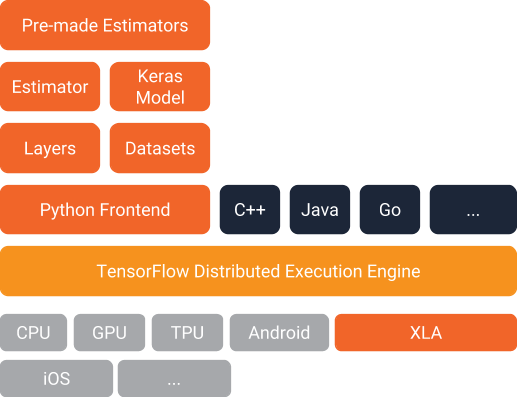

In [1]:
from IPython.display import Image
Image(filename='imgs/tflow-stack.png', width=600)

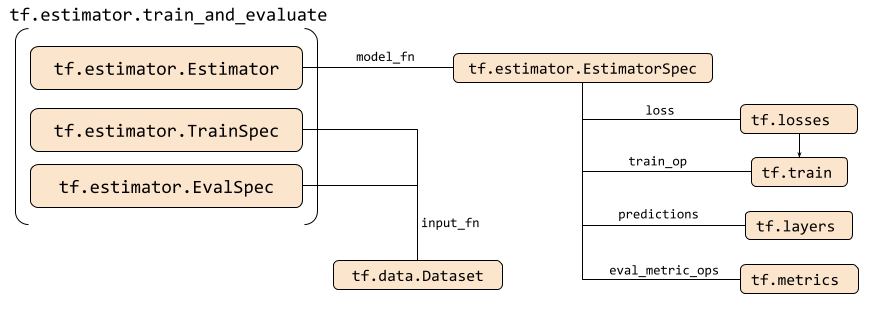

In [2]:
Image(filename='imgs/tflow_estimator_api.png', width=600)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mlutils
%matplotlib inline
import pandas as pd
from sklearn.datasets import make_moons
print tf.__version__

/opt/anaconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1.9.0


In [4]:
from sklearn.datasets import make_moons
X_data,y_data = make_moons(300, noise=.2)

In [5]:
def get_dataset(X_data, y_data, repeat, batch_size, shuffle=True):
    d1 = tf.data.Dataset.from_tensor_slices((tf.constant(X_data, dtype=tf.float32), 
                                             tf.constant(y_data.reshape(-1,1), dtype=tf.float32)))
    if shuffle:
        d1 = d1.shuffle(buffer_size=200)
    d1 = d1.repeat(repeat)
    d1 = d1.map(lambda X,y: ({"x0": X[0], "x1": X[1]} ,y))
    d1 = d1.batch(batch_size)    
    return d1


def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    bc1 = tf.feature_column.bucketized_column(source_column = c1,boundaries = list(np.linspace(-2,2,10)))
    bc2 = tf.feature_column.bucketized_column(source_column = c2,boundaries = list(np.linspace(-2,2,10)))
    return [bc1, bc2]


## Usando un estimador predefinido (_premade estimator_)

In [6]:
classifier = tf.estimator.LinearClassifier(feature_columns=get_features_defs(), model_dir="models")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb05904fdd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'models', '_train_distribute': None, '_save_summary_steps': 100}


observa que `get_dataset` debe de devolver un `Dataset` (la llamada a `make_iterator*` la realiza el estimador)

In [16]:
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=10, batch_size=10, shuffle=True)
test_input_fn  = lambda: get_dataset(X_data, y_data, repeat=1, batch_size=len(X_data), shuffle=False)

train estimator

In [17]:
tf.logging.set_verbosity(tf.logging.INFO)
!rm -rf models
classifier.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/model.ckpt.
INFO:tensorflow:loss = 6.931472, step = 1
INFO:tensorflow:global_step/sec: 183.563
INFO:tensorflow:loss = 2.679837, step = 101 (0.546 sec)
INFO:tensorflow:global_step/sec: 338.025
INFO:tensorflow:loss = 1.3142375, step = 201 (0.297 sec)
INFO:tensorflow:Saving checkpoints for 300 into models/model.ckpt.
INFO:tensorflow:Loss for final step: 1.9019535.


**Evaluamos** el estimador. Observa que el propio estimador ya tiene unas métricas predefinidas.

In [18]:
result = classifier.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-22-22:27:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-22-22:27:25
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.95666665, accuracy_baseline = 0.5, auc = 0.9859556, auc_precision_recall = 0.9881345, average_loss = 0.19339997, global_step = 300, label/mean = 0.5, loss = 58.01999, precision = 0.9724138, prediction/mean = 0.49645212, recall = 0.94
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 300: models/model.ckpt-300


In [19]:
result

{'accuracy': 0.95666665,
 'accuracy_baseline': 0.5,
 'auc': 0.9859556,
 'auc_precision_recall': 0.9881345,
 'average_loss': 0.19339997,
 'global_step': 300,
 'label/mean': 0.5,
 'loss': 58.01999,
 'precision': 0.9724138,
 'prediction/mean': 0.49645212,
 'recall': 0.94}

obtenemos las predicciones

In [23]:
predict_input_fn = lambda: get_dataset(X_data, np.ones(len(X_data)), repeat=1, batch_size=len(X_data), shuffle=False)
preds = classifier.predict(predict_input_fn)
print preds

<generator object predict at 0x7fb003688d20>


observa que preds es un `generator`. Esto es para facilitar el _streaming_ desde los datos de entrada hasta la predicción, sin requerir que quepan todos los datos en memoria

In [24]:
preds = [i for i in preds]
print "predictions obtained", len(preds)
preds[0]

predictions obtained 300


{'class_ids': array([1]),
 'classes': array(['1'], dtype=object),
 'logistic': array([0.9848503], dtype=float32),
 'logits': array([4.1745043], dtype=float32),
 'probabilities': array([0.01514977, 0.9848503 ], dtype=float32)}

obtain only prediction label

In [25]:
tf.logging.set_verbosity(tf.logging.WARN)
preds = np.r_[[i["class_ids"][0] for i in preds]]
np.mean(preds==y_data)

0.9566666666666667

wrap it into a prediction function to work with the rest of Python

In [26]:
def predict(X_data, classifier):
    
    predict_input_fn = lambda: get_dataset(X_data, np.ones((len(X_data),1)), repeat=1, batch_size=len(X_data), shuffle=False)
    preds = classifier.predict(predict_input_fn)
    print preds
    preds = [i for i in preds]
    preds = np.r_[[i["class_ids"][0] for i in preds]]
    print "obtained prediction", preds.shape, X_data.shape
    return preds.astype(int)

<generator object predict at 0x7fb008063500>
obtained prediction (40000,) (40000, 2)


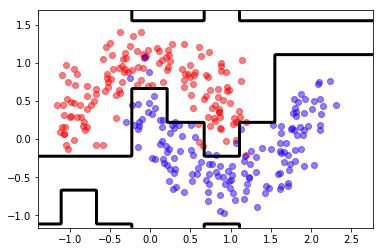

In [27]:
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

### o una red neuronal

pruébalo con:

- los datos originales (sin columnas añadidas)
- algunas columnas transformadas (bucketize)

In [28]:
def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    bc1 = tf.feature_column.bucketized_column(source_column = c1,boundaries = list(np.linspace(-2,2,10)))
    bc2 = tf.feature_column.bucketized_column(source_column = c2,boundaries = list(np.linspace(-2,2,10)))
    return [c1, c2, bc1, bc2]



In [29]:
classifier = tf.estimator.DNNClassifier(hidden_units=[5,5], feature_columns=get_features_defs(), model_dir="models")

tf.logging.set_verbosity(tf.logging.INFO)
!rm -rf models
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=100, batch_size=30, shuffle=True)
classifier.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/model.ckpt.
INFO:tensorflow:loss = 20.821035, step = 1
INFO:tensorflow:global_step/sec: 189.675
INFO:tensorflow:loss = 2.4703383, step = 101 (0.529 sec)
INFO:tensorflow:global_step/sec: 234.474
INFO:tensorflow:loss = 8.111084, step = 201 (0.426 sec)
INFO:tensorflow:global_step/sec: 306.276
INFO:tensorflow:loss = 5.7091093, step = 301 (0.326 sec)
INFO:tensorflow:global_step/sec: 284.548
INFO:tensorflow:loss = 3.6063433, step = 401 (0.352 sec)
INFO:tensorflow:global_step/sec: 256.931
INFO:tensorflow:loss = 5.7226725, step = 501 (0.390 sec)
INFO:tensorflow:global_step/sec: 258.759
INFO:tensorflow:loss = 4.7018485, step = 601 (0.387 sec)
INFO:tensorflow:global_step/sec: 268.876
INFO:tensorflow:loss = 1.81

<generator object predict at 0x7fb00820c2d0>
obtained prediction (40000,) (40000, 2)


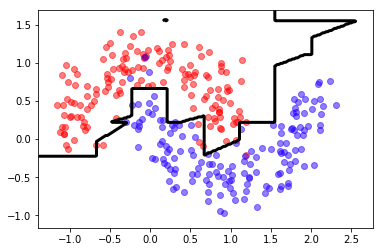

In [30]:
tf.logging.set_verbosity(tf.logging.WARN)
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

con un wide'n'deep.

Tutorial
https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html


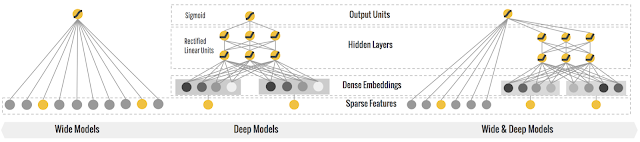

In [31]:
from IPython.display import Image
Image(filename='imgs/widedeep.png')

pruébalo con distintas combinaciones de columnas lineales y dnn

In [32]:
def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    bc1 = tf.feature_column.bucketized_column(source_column = c1,boundaries = list(np.linspace(-2,2,10)))
    bc2 = tf.feature_column.bucketized_column(source_column = c2,boundaries = list(np.linspace(-2,2,10)))
    return c1, c2, bc1, bc2

In [33]:
c1,c2,bc1,bc2 = get_features_defs()

classifier = tf.estimator.DNNLinearCombinedClassifier(dnn_hidden_units=[5,5], 
                                                      linear_feature_columns=[c1],
                                                      dnn_feature_columns=[c2, bc1, bc2],
                                                       model_dir="models")


In [34]:
tf.logging.set_verbosity(tf.logging.INFO)
!rm -rf models
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=100, batch_size=30, shuffle=True)
classifier.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/model.ckpt.
INFO:tensorflow:loss = 23.148796, step = 1
INFO:tensorflow:global_step/sec: 146.328
INFO:tensorflow:loss = 21.33104, step = 101 (0.686 sec)
INFO:tensorflow:global_step/sec: 217.349
INFO:tensorflow:loss = 20.743912, step = 201 (0.459 sec)
INFO:tensorflow:global_step/sec: 243.324
INFO:tensorflow:loss = 21.168894, step = 301 (0.414 sec)
INFO:tensorflow:global_step/sec: 253.882
INFO:tensorflow:loss = 20.518415, step = 401 (0.392 sec)
INFO:tensorflow:global_step/sec: 263.054
INFO:tensorflow:loss = 19.885916, step = 501 (0.381 sec)
INFO:tensorflow:global_step/sec: 258.886
INFO:tensorflow:loss = 20.172173, step = 601 (0.386 sec)
INFO:tensorflow:global_step/sec: 234.996
INFO:tensorflow:loss = 20.2

<generator object predict at 0x7fafc1315690>
obtained prediction (40000,) (40000, 2)


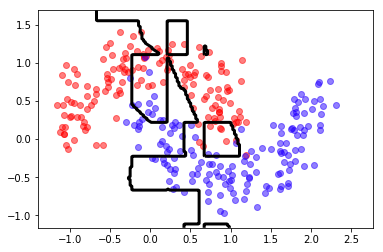

In [35]:
tf.logging.set_verbosity(tf.logging.WARN)
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

### train, eval specs, run config

observa que:

- cada `checkpoint` salva el estado del entrenamiento
- el entrenamiento continúa desde el último `checkpoint` existente en `model_dir`.
- se realiza una evaluación cada `checkpoint` o cada `throttle_secs` o cada vez que se inicia un `epoch` (`repeat`)

In [36]:
def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    return [c1, c2]

In [58]:
X_data,y_data = make_moons(500, noise=.2)

train_spec = tf.estimator.TrainSpec(
    input_fn = lambda: get_dataset(X_data, y_data, repeat=2, batch_size=10, shuffle=True),
    max_steps=200)

eval_spec = tf.estimator.EvalSpec(
    input_fn = lambda: get_dataset(X_data, y_data, repeat=4, batch_size=20, shuffle=True),
    steps=3,
    throttle_secs = 30,
    start_delay_secs = 10)

run_config = tf.estimator.RunConfig(
    save_checkpoints_steps = 1000,
    keep_checkpoint_max = 1,
    model_dir="models")

comenta la primera línea de la siguiente celda si quieres **continuar un entrenamiento anterior**

In [59]:
!rm -rf models

tf.logging.set_verbosity(tf.logging.INFO)

classifier = tf.estimator.DNNClassifier(hidden_units=[10,5], 
                                        feature_columns=get_features_defs(), 
                                        config=run_config)
r = tf.estimator.train_and_evaluate(classifier, train_spec=train_spec, eval_spec=eval_spec)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_global_id_in_cluster': 0, '_session_config': None, '_keep_checkpoint_max': 1, '_tf_random_seed': None, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fafe1d18950>, '_model_dir': 'models', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_service': None, '_device_fn': None, '_save_summary_steps': 100, '_num_ps_replicas': 0}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 30 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
I

<generator object predict at 0x7fafc0dd58c0>
obtained prediction (40000,) (40000, 2)


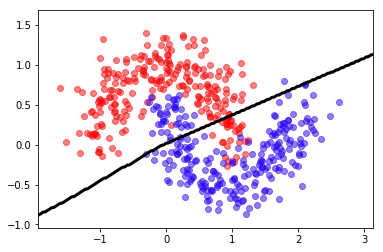

In [60]:
tf.logging.set_verbosity(tf.logging.WARN)
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

## Creación de estimadores propios (_custom estimators_)


observa que:

- las funciones `train_input_fn` y `test_input_fn` tienen que devolver un iterador (no como anteriormente)
- la función `my_model_fn` **crea un grafo computacional** y además, tiene que tener en cuenta tres modos de llamada **TRAIN**, **EVAL**, **PREDICT**.
- el orden de definición ha de ser el dado, es decir, primero **PREDICT**, ya que en ese caso nos llamarán sin `labels`.
- definimos las métricas que asociamos al estimador


In [61]:
X_data,y_data = make_moons(600, noise=.25)

In [62]:
def my_model_fn(
   features, # This is batch_features from input_fn
   labels,   # This is batch_labels from input_fn
   mode,     # An instance of tf.estimator.ModeKeys
   params):

    # === PART 1, BUILD COMPUTATIONAL GRAPH
    input_layer = tf.feature_column.input_layer(features, params['feature_columns'])

    t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32)
    b = tf.Variable(initial_value=tf.random_uniform([1]), name="b", dtype=tf.float32)

    y_hat = tf.sigmoid(b+tf.matmul(tf.cast(input_layer, tf.float32),t))
    
    # Compute predictions.
    predicted_classes = tf.cast(y_hat>0.5, tf.float32)
    
    # === PART 2, PREDICT MODE
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'y_hat': y_hat
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    flabels = tf.cast(labels,tf.float32)
    loss  = -tf.reduce_mean(flabels*tf.log(y_hat)+(1-flabels)*tf.log(1-y_hat))    

    # === PART 3, EVALUATION MODE
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes,name='acc_op')
    metrics =  {"accuracy": accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    
    # === PART 4, TRAINING MODE
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.01)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [75]:
def get_features_defs():
    c1 = tf.feature_column.numeric_column("x0")
    c2 = tf.feature_column.numeric_column("x1")
    return [c1, c2]

tf.reset_default_graph()
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=10, batch_size=5, shuffle=True).make_one_shot_iterator().get_next()
test_input_fn  = lambda: get_dataset(X_data, y_data, repeat=1, batch_size=len(X_data), shuffle=False).make_one_shot_iterator().get_next()


tf.logging.set_verbosity(tf.logging.INFO)


classifier = tf.estimator.Estimator(
    model_fn=my_model_fn, #lambda features,labels, params, mode: my_model_fn(features,labels,params, mode),
    params={
        'feature_columns': get_features_defs(),
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0082e14d0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmpxSzS23', '_train_distribute': None, '_save_summary_steps': 100}


In [76]:
tf.logging.set_verbosity(tf.logging.INFO)
classifier.train(train_input_fn, max_steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxSzS23/model.ckpt.
INFO:tensorflow:loss = 0.6108055, step = 1
INFO:tensorflow:global_step/sec: 289.254
INFO:tensorflow:loss = 0.7446926, step = 101 (0.348 sec)
INFO:tensorflow:global_step/sec: 374.799
INFO:tensorflow:loss = 0.7871415, step = 201 (0.266 sec)
INFO:tensorflow:global_step/sec: 402.88
INFO:tensorflow:loss = 0.3846439, step = 301 (0.249 sec)
INFO:tensorflow:global_step/sec: 457.011
INFO:tensorflow:loss = 0.4279821, step = 401 (0.219 sec)
INFO:tensorflow:global_step/sec: 467.087
INFO:tensorflow:loss = 0.2105709, step = 501 (0.213 sec)
INFO:tensorflow:global_step/sec: 473.283
INFO:tensorflow:loss = 0.51426464, step = 601 (0.211 sec)
INFO:tensorflow:global_step/sec: 436.924
INFO:tensorflow:lo

In [77]:
eval_result = classifier.evaluate(input_fn=test_input_fn)
eval_result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-22-22:36:39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxSzS23/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-22-22:36:40
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.825, global_step = 1200, loss = 0.38648438
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1200: /tmp/tmpxSzS23/model.ckpt-1200


{'accuracy': 0.825, 'global_step': 1200, 'loss': 0.38648438}

In [78]:
preds = [i for i in classifier.predict(input_fn=test_input_fn)]



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpxSzS23/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<generator object predict at 0x7fb0082f0b90>
obtained prediction (40000, 1) (40000, 2)


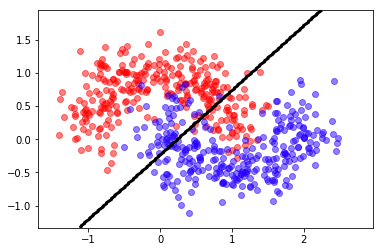

In [79]:
tf.logging.set_verbosity(tf.logging.WARN)
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

### creación de una métrica propia

tu métrica ha de **definirse como un tensor**, es decir, como una expresión que después se evaluará en una sesión TF.

Pregunta, ¿un `print` en la función `tpr` en qué momento sale?

    for metrics in tf.estimator.Estimator, all metrics functions return two Ops: `value_op` and  `update_op`. 
    Estimator.evaluate calls the `update_op` for each batch of the data in input source and, once it is exhausted, it calls the `value_op` to get the metric values.
    

In [85]:
X_data,y_data = make_moons(600, noise=.25)
print np.sum(y_data)
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=5, batch_size=10, shuffle=True).make_one_shot_iterator().get_next()
test_input_fn  = lambda: get_dataset(X_data, y_data, repeat=1, batch_size=len(X_data), shuffle=False).make_one_shot_iterator().get_next()



def tpr(labels, predictions):

    positives      = tf.Variable(tf.constant(0, dtype=tf.float32), trainable=False, name="positives")    
    positives_hits = tf.Variable(tf.constant(0, dtype=tf.float32), trainable=False, name="positives_hits")    

    predictions_for_positives = tf.cast(tf.boolean_mask(tf.reshape(predictions, (-1,1)), tf.equal(labels,1)), tf.float32)

    this_batch_positives      = tf.cast(tf.reduce_sum(labels), dtype=tf.float32)
    this_batch_positives_hits = tf.cast(tf.reduce_sum(predictions_for_positives), dtype=tf.float32)
    
    update_op_p  = tf.assign_add(positives, this_batch_positives)
    update_op_ph = tf.assign_add(positives_hits, this_batch_positives_hits)
    
        
    return positives_hits/positives, tf.group(update_op_ph,update_op_p)


300


In [ ]:
tf.reset_default_graph()

preds = tf.Variable(initial_value=tf.random_uniform(([10,1])), dtype=tf.float32)
preds = tf.cast(preds>.5, tf.int32)

labels = tf.Variable(initial_value=tf.random_uniform(([10,1])), dtype=tf.float32)
labels = tf.cast(labels>.5, tf.int32)

positives = tf.cast(tf.boolean_mask(preds, tf.equal(labels,1)), tf.float32)
tpr = tf.reduce_mean(positives)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    npreds = sess.run(preds)
    nlabs  = sess.run(labels)
    
    nposities = sess.run(positives)
    ntpr = sess.run(tpr)

In [80]:


def my_model_fn(
   features, # This is batch_features from input_fn
   labels,   # This is batch_labels from input_fn
   mode,     # An instance of tf.estimator.ModeKeys
   params):

    # === PART 1, BUILD COMPUTATIONAL GRAPH
    input_layer = tf.feature_column.input_layer(features, params['feature_columns'])

    t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32)
    b = tf.Variable(initial_value=tf.random_uniform([1]), name="b", dtype=tf.float32)

    y_hat = tf.sigmoid(b+tf.matmul(tf.cast(input_layer, tf.float32),t))
    
    # Compute predictions.
    predicted_classes = tf.cast(y_hat>0.5, tf.float32)
    
    # === PART 2, PREDICT MODE
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'y_hat': y_hat
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    flabels = tf.cast(labels,tf.float32)
    loss  = -tf.reduce_mean(flabels*tf.log(y_hat)+(1-flabels)*tf.log(1-y_hat))    

    # === PART 3, EVALUATION MODE
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes,name='acc_op')
    true_positive_rate = tpr(labels, predicted_classes)
    metrics =  {"accuracy": accuracy, "tpr": true_positive_rate}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    
    # === PART 4, TRAINING MODE
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=.01)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

300


In [81]:
tf.reset_default_graph()
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=10, batch_size=5, shuffle=True).make_one_shot_iterator().get_next()
test_input_fn  = lambda: get_dataset(X_data, y_data, repeat=1, batch_size=len(X_data), shuffle=False).make_one_shot_iterator().get_next()


tf.logging.set_verbosity(tf.logging.INFO)


classifier = tf.estimator.Estimator(
    model_fn=my_model_fn, #lambda features,labels, params, mode: my_model_fn(features,labels,params, mode),
    params={
        'feature_columns': get_features_defs(),
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0036f8350>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_device_fn': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/tmp/tmploROOf', '_train_distribute': None, '_save_summary_steps': 100}


In [82]:
tf.logging.set_verbosity(tf.logging.INFO)
classifier.train(train_input_fn, max_steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmploROOf/model.ckpt.
INFO:tensorflow:loss = 0.586472, step = 1
INFO:tensorflow:global_step/sec: 293.684
INFO:tensorflow:loss = 0.87085855, step = 101 (0.342 sec)
INFO:tensorflow:global_step/sec: 488.675
INFO:tensorflow:loss = 0.5931839, step = 201 (0.205 sec)
INFO:tensorflow:global_step/sec: 435.882
INFO:tensorflow:loss = 0.65129745, step = 301 (0.230 sec)
INFO:tensorflow:global_step/sec: 417.59
INFO:tensorflow:loss = 0.6121888, step = 401 (0.239 sec)
INFO:tensorflow:global_step/sec: 451.482
INFO:tensorflow:loss = 0.45413065, step = 501 (0.221 sec)
INFO:tensorflow:global_step/sec: 450.885
INFO:tensorflow:loss = 0.45273438, step = 601 (0.226 sec)
INFO:tensorflow:global_step/sec: 360.581
INFO:tensorflow:

In [83]:
eval_result = classifier.evaluate(input_fn=test_input_fn)
eval_result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-22-22:38:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmploROOf/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-08-22-22:38:30
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.81166667, global_step = 1200, loss = 0.40308732, tpr = 0.82666665
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1200: /tmp/tmploROOf/model.ckpt-1200


{'accuracy': 0.81166667,
 'global_step': 1200,
 'loss': 0.40308732,
 'tpr': 0.82666665}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmploROOf/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
<generator object predict at 0x7fafe1d69190>
obtained prediction (40000, 1) (40000, 2)


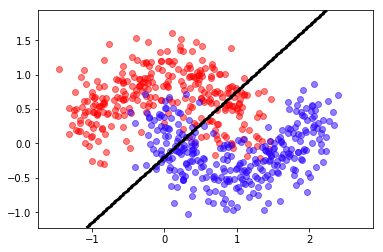

In [84]:
preds = [i for i in classifier.predict(input_fn=test_input_fn)]
tf.logging.set_verbosity(tf.logging.WARN)
mlutils.plot_2D_boundary(lambda X: predict(X, classifier), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

In [77]:
tf.reset_default_graph()
preds = tf.Variable(initial_value=tf.random_uniform(([10,1])), dtype=tf.float32)
preds = tf.cast(preds>.5, tf.int32)

labels = tf.Variable(initial_value=tf.random_uniform(([10,1])), dtype=tf.float32)
labels = tf.cast(labels>.5, tf.int32)

positives = tf.cast(tf.boolean_mask(preds, tf.equal(labels,1)), tf.float32)
tpr = tf.reduce_mean(positives)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    npreds = sess.run(preds)
    nlabs  = sess.run(labels)
    
    nposities = sess.run(positives)
    ntpr = sess.run(tpr)

In [78]:
positives

<tf.Tensor 'Cast_2:0' shape=(?,) dtype=float32>

In [79]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    npreds = sess.run(preds)
    nlabs  = sess.run(labels)
    
    nposities = sess.run(positives)
    ntpr = sess.run(tpr)

In [80]:
print npreds

[[1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]]


In [81]:
print nlabs

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]]


In [82]:
print nposities

[1. 0. 1. 1. 0.]


In [83]:
npreds[nlabs==1]

array([1, 0, 1, 1, 0], dtype=int32)

In [84]:
ntpr

0.6

In [ ]:
def my_auc(labels, predictions):
    return {'auc': tf.metrics.auc(labels, predictions['logistic'])}

In [18]:
tf.metrics.auc?


In [55]:
tf.estimator.TrainSpec?

In [ ]:
test_input_fn  = lambda: get_dataset(X_data, y_data, repeat=1, batch_size=len(X_data), shuffle=True)

In [51]:
classifier = tf.estimator.DNNClassifier(hidden_units=[5,5], feature_columns=get_features_defs(), model_dir="models")

tf.logging.set_verbosity(tf.logging.INFO)
!rm -rf models
train_input_fn = lambda: get_dataset(X_data, y_data, repeat=100, batch_size=30, shuffle=True)
classifier.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into models/model.ckpt.
INFO:tensorflow:loss = 21.211357, step = 1
INFO:tensorflow:global_step/sec: 226.62
INFO:tensorflow:loss = 10.97101, step = 101 (0.443 sec)
INFO:tensorflow:global_step/sec: 193.469
INFO:tensorflow:loss = 9.737086, step = 201 (0.517 sec)
INFO:tensorflow:global_step/sec: 206.336
INFO:tensorflow:loss = 10.779773, step = 301 (0.486 sec)
INFO:tensorflow:global_step/sec: 269.269
INFO:tensorflow:loss = 5.4749236, step = 401 (0.370 sec)
INFO:tensorflow:global_step/sec: 290.6
INFO:tensorflow:loss = 8.646041, step = 501 (0.343 sec)
INFO:tensorflow:global_step/sec: 340.719
INFO:tensorflow:loss = 10.00528, step = 601 (0.293 sec)
INFO:tensorflow:global_step/sec: 323.116
INFO:tensorflow:loss = 9.36288, s

In [49]:
k = train_input_fn()

({'x0': tf.float32, 'x1': tf.float32}, tf.float32)

### model_fn, estimator spec

### run config

### saving and restoring models

http://amygdala.github.io/ml/tensorflow/cloud_ml_engine/2018/01/26/tf.html
https://towardsdatascience.com/how-to-configure-the-train-and-evaluate-loop-of-the-tensorflow-estimator-api-45c470f6f8d

# Experiment, train spec, etc.

understand projections in tensorboard